We are simulating an insertion bias into piRNA clusters. The bias may go from -100% to 100%

-100%: complete bias against piRNA clusters; no TE will ever jump into a cluster
+100% complete bias towards piRNA clusters; all TEs will jump into a piRNA cluster
0% no bias; the probabiltiy to jump into a piRNA cluster is bascially the total size of the cluster (as fraction)
But how to model this with some mathematical equation? My idea is actually based on the equations used for computing the allele frequency of selected allele.

Here is the implementation in R

pc: probability for a cluster insertion; computes the probability that a TE will jump into a piRNA cluster, give some insertion bias (bias) and some total size of the piRNA clusters (clufrac)
bias: insertion bias of the TE; from -100 to +100
clufrac: total size of the piRNA clusters in percent of genome; eg in Drosophila piRNA clusters account for 3% of the genome

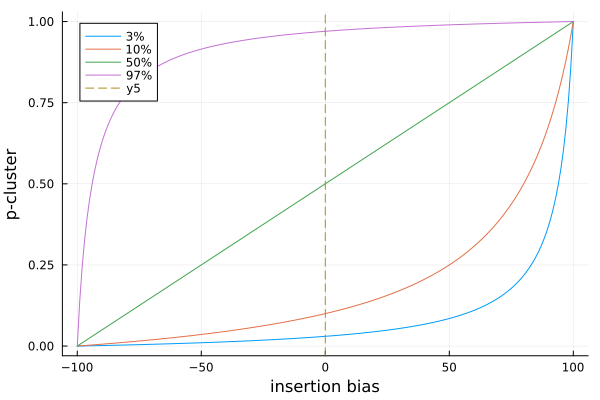

In [13]:

using DataFrames
using Plots

function pc(bias, clufrac)
    genfrac = 1.0 - clufrac
    bias = bias ./ 100
    clufit = (bias .+ 1.0) ./ 2.0
    genfit = 1.0 .- clufit
    totfit = clufrac .* clufit .+ genfrac .* genfit
    p = (clufrac .* clufit) ./ totfit
    return p
end

bias_range = -100:100
p3 = pc(bias_range, 0.03)
p10 = pc(bias_range, 0.1)
p50 = pc(bias_range, 0.5)
p97 = pc(bias_range, 0.97)

df = DataFrame(
    bias = repeat(bias_range, outer = 4),
    insprob = vcat(p3, p10, p50, p97),
    cluster_size = repeat(["3%", "10%", "50%", "97%"], inner = length(bias_range)),
)



p = plot()
for cs in unique(df.cluster_size)
    df_subset = df[df.cluster_size .== cs, :]
    plot!(df_subset.bias, df_subset.insprob, label = cs)
end

xlabel!("insertion bias")
ylabel!("p-cluster")
vline!([0], linestyle=:dash)

display(p)



In [42]:
using CSV, DataFrames

# Define column names
column_names = ["rep", "gen", "popstat", "spacer_1", "fwte", "avw", "min_w", "avtes", "avpopfreq",
                "fixed","spacer_2", "phase", "fwcli", "avcli", "fixcli", "spacer_3",
                "avbias",	"3tot",	"3cluster",	"spacer_4", "sampleid"]

# Define column types

column_types = Dict(
    "rep" => Union{Missing, Int}, 
    "gen" => Union{Missing, Int}, 
    "popstat" => Union{Missing, String},
    "spacer_1" => Union{Missing, Char}, 
    "fwte" => Union{Missing, Float64}, 
    "avw" => Union{Missing, Float64}, 
    "min_w" => Union{Missing, Float64}, 
    "avtes" => Union{Missing, Float64}, 
    "avpopfreq" => Union{Missing, Float64}, 
    "fixed" => Union{Missing, String},
    "spacer_2" => Union{Missing, Char}, 
    "phase" => Union{Missing, String}, 
    "fwcli" => Union{Missing, Float64}, 
    "avcli" => Union{Missing, Float64}, 
    "fixcli" => Union{Missing, Float64}, 
    "spacer_3" => Union{Missing, Char}, 
    "avbias" => Union{Missing, Float64}, 
    "3tot" => Union{Missing, String}, 
    "3cluster" => Union{Missing, String}, 
    "spacer_4" => Union{Missing, Char}, 
    "sampleid" => Union{Missing, String}
)


# Initialize an empty list to store file paths
file_paths = []

# Loop through numbers 1 to 21 to generate file paths
for i in 1:21
    push!(file_paths, "result_$i.out")
end


# Initialize an empty DataFrame with desired columns
df = DataFrame()
for col in column_names
    df[!, col] = Vector{Union{Missing, String}}() 
end 

In [43]:
# Read and concatenate all the output files
for file in file_paths
    temp_df = CSV.File(file, 
                      header=column_names, 
                      delim='\t', 
                      missingstring="missing",
                      ignoreemptyrows=true, 
                      silencewarnings=true, 
                      comment="#",
                      types=column_types,
                      ntasks=1) |> DataFrame  # Disable multithreaded parsing
                      
    # Make sure all columns are in temp_df before appending
    for col in column_names
        if !hasproperty(temp_df, col)
            temp_df[!, col] = missing
        end
    end
    
    # Filter out lines starting with "Invade" in temp_df
    temp_df = filter(row -> !startswith(string(row[:rep]), "Invade"), temp_df)

    append!(df, temp_df, cols=:union)
end 

In [39]:
df

Row,rep,gen,popstat,spacer_1,fwte,avw,min_w,avtes,avpopfreq,fixed,spacer_2,phase,fwcli,avcli,fixcli,spacer_3,avbias,3tot,3cluster,spacer_4,sampleid,Column22
,String?,Any,String?,String?,Any,Any,Any,Any,Any,Any,String?,String?,Any,Any,Any,String?,Any,String?,String?,String?,String?,String3?
1,1,0,ok,|,1.0,1.0,1.0,1001.0,0.5,0,|,shot,1.0,35.0,0,|,-99.9,"1000.00(-100),1.00(0)","34.00(-100),1.00(0)",|,mb100,
2,1,1,ok,|,1.0,1.0,1.0,991.01,0.5,0,|,shot,1.0,34.67,0,|,-99.9,"990.00(-100),1.01(0)","33.66(-100),1.01(0)",|,mb100,
3,2,0,ok,|,1.0,1.0,1.0,1001.0,0.5,0,|,shot,1.0,35.0,0,|,-99.9,"1000.00(-100),1.00(0)","34.00(-100),1.00(0)",|,mb100,
4,2,1,ok,|,1.0,1.0,1.0,994.01,0.5,0,|,shot,1.0,34.77,0,|,-99.9,"993.00(-100),1.01(0)","33.76(-100),1.01(0)",|,mb100,
5,3,0,ok,|,1.0,1.0,1.0,1001.0,0.5,0,|,shot,1.0,35.0,0,|,-99.9,"1000.00(-100),1.00(0)","34.00(-100),1.00(0)",|,mb100,
6,3,1,ok,|,1.0,1.0,1.0,991.51,0.5,0,|,shot,1.0,34.69,0,|,-99.9,"990.50(-100),1.01(0)","33.68(-100),1.01(0)",|,mb100,
7,4,0,ok,|,1.0,1.0,1.0,1001.0,0.5,0,|,shot,1.0,35.0,0,|,-99.9,"1000.00(-100),1.00(0)","34.00(-100),1.00(0)",|,mb100,
8,4,1,ok,|,1.0,1.0,1.0,996.7,0.5,0,|,shot,1.0,34.86,0,|,-99.9,"995.70(-100),1.00(0)","33.85(-100),1.00(0)",|,mb100,
9,5,0,ok,|,1.0,1.0,1.0,1001.0,0.5,0,|,shot,1.0,35.0,0,|,-99.9,"1000.00(-100),1.00(0)","34.00(-100),1.00(0)",|,mb100,
